# Result Validation

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from gpytorch import settings
import torch
import torchvision.transforms as transforms
import gpytorch
import pandas as pd

In [3]:
DATASET_PATH = '/home/alberto/Desktop/datasets/histopathologic-cancer-detection/'

In [4]:
model_type = 'resnet18'

# dataset = 'x_ray_binary'
dataset = 'cancer'

is_debug = False

In [5]:
import json
def load_configuration(filename, path='./configuration'):
    with open(f'{path}/{filename}') as f:
        configuration = json.load(f)
    return configuration

In [6]:
config = load_configuration(filename=f'bayes-{model_type}-{dataset}.json', path='./../deep_gp/configuration')
batch_size = 800
img_size = config['img_size']
n_channels = config['n_channels']
num_likelihood_samples = config['num_likelihood_samples']
# n of samples used
settings.num_likelihood_samples._set_value(num_likelihood_samples)

if is_debug:
    batch_size = 64

In [7]:
# aug_trans = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]
common_trans = [
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6], std=[0.2])
]

transform_train = transforms.Compose(common_trans)
transform_val = transforms.Compose(common_trans)

use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)

In [8]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from PIL import Image
from torchvision.models import ResNet
from torchvision.models.resnet import BasicBlock
import torch.utils.model_zoo as model_zoo
import math
import torch
from gpytorch import settings
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import Likelihood
from torch.distributions import Categorical

class HistoPathologicCancer(Dataset):
    """Histo-Pathologic Cancer Dataset with binary labeling: Finding/No-Finding"""

    def __init__(self, path=None, img_size=64, dataset_type='train', transform=None, n_channels=3, is_debug=False):
        self.path = path if path is not None \
            else '/home/alberto/Desktop/datasets/histopathologic-cancer-detection/'
        self.img_size = img_size
        self.dataset_type = dataset_type
        if self.dataset_type not in ['train', 'validation', 'test']:
            raise RuntimeError

        if self.dataset_type in ['train', 'validation']:
            self.is_training = True
        else:
            self.is_training = False

        self.n_channels = n_channels
        self.is_debug = is_debug

        # define transformation
        self.transform = transform
        if self.transform is None:
            self.transform = transforms.Compose([
                                transforms.Resize((img_size, img_size)),
                                transforms.ToTensor()])

        self.transform_target = transforms.ToTensor()

        if self.is_training:
            self.df_data = pd.read_csv(os.path.join(self.path, 'train_labels.csv'))

            if is_debug:
                self.df_data = self.df_data[:512]

            # create training/validation set
            train, validation = train_test_split(self.df_data, random_state=42, shuffle=True, test_size=0.2)
            if self.dataset_type == 'train':
                self.df_data = train
            elif self.dataset_type == 'validation':
                self.df_data = validation
        else:
            self.df_data = os.listdir(os.path.join(self.path, 'test'))
            if is_debug:
                self.df_data = self.df_data[:512]

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        if self.is_training:
            return self._get_img_and_label(idx)
        else:
            item = self.df_data[idx]
            img = self.get_rgb_image_from_file(os.path.join(self.path, 'test', item))
            img = self.transform(img)
            return img, item[:-4]

    def _get_img_and_label(self, idx):
        item = self.df_data.iloc[idx]
        img = self.get_rgb_image_from_file(os.path.join(self.path, 'train', ''.join([item['id'],
                                                                                     '.tif'])))
        img = self.transform(img)
        label = np.array(item['label'])
        label = torch.from_numpy(label)
        return img, label

    def load_image_from_file(self, filename):
        return Image.open(filename)

    def get_rgb_image_from_file(self, filename):
        return self.load_image_from_file(filename).convert('RGB')

    def get_grayscale_image_from_file(self, filename):
        return self.load_image_from_file(filename).convert('L')


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


class ResNet18FeatureExtractor(ResNet):
    '''
    Feature Extractor from ResNet 18
    '''
    def __init__(self, num_classes, pretrained=True):
        self.num_classes = num_classes
        self.pretrained = pretrained
        super(ResNet18FeatureExtractor, self).__init__(block=BasicBlock, layers=[2, 2, 2, 2],)

        if pretrained:
            self.load_state_dict(model_zoo.load_url(model_urls['resnet18']))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x
    

class GaussianProcessLayer(gpytorch.models.AdditiveGridInducingVariationalGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        super(GaussianProcessLayer, self).__init__(grid_size=grid_size, grid_bounds=[grid_bounds],
                                                   num_dim=num_dim, mixing_params=False, sum_output=False)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    
# Create DKL Model
class DKLModel(gpytorch.Module):
    def __init__(self, feature_extractor, num_dim, grid_bounds=(-10., 10.)):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim

    def forward(self, x):
        features = self.feature_extractor(x)
        features = gpytorch.utils.grid.scale_to_bounds(features, self.grid_bounds[0], self.grid_bounds[1])
        res = self.gp_layer(features)
        return res


class SoftmaxLikelihood(Likelihood):
    """
    Implements the Softmax (multiclass) likelihood used for GP classification.
    """

    def __init__(self, num_features, n_classes, is_detail_eval=False, mixing_weights_prior=None):
        super(SoftmaxLikelihood, self).__init__()
        self.num_features = num_features
        self.n_classes = n_classes
        self.register_parameter(
            name="mixing_weights",
            parameter=torch.nn.Parameter(torch.ones(n_classes, num_features).fill_(1.0 / num_features)),
        )
        if mixing_weights_prior is not None:
            self.register_prior("mixing_weights_prior", mixing_weights_prior, "mixing_weights")
        self.is_detail_eval = is_detail_eval

    def forward(self, latent_func):
        if not isinstance(latent_func, MultivariateNormal):
            raise RuntimeError(
                "SoftmaxLikelihood expects a multi-variate normally distributed latent function to make predictions"
            )

        n_samples = settings.num_likelihood_samples.value()
        samples = latent_func.rsample(sample_shape=torch.Size((n_samples,)))
        if samples.dim() == 2:
            samples = samples.unsqueeze(-1).transpose(-2, -1)
        samples = samples.permute(1, 2, 0).contiguous()  # Now n_featuers, n_data, n_samples
        if samples.ndimension() != 3:
            raise RuntimeError("f should have 3 dimensions: features x data x samples")
        num_features, n_data, _ = samples.size()
        if num_features != self.num_features:
            raise RuntimeError("There should be %d features" % self.num_features)

        mixed_fs = self.mixing_weights.matmul(samples.view(num_features, n_samples * n_data))
        softmax = torch.nn.functional.softmax(mixed_fs.t(), 1).view(n_data, n_samples, self.n_classes)

        if self.is_detail_eval:
            return Categorical(probs=softmax.mean(1)), softmax, mixed_fs

        return Categorical(probs=softmax.mean(1))

    def variational_log_probability(self, latent_func, target):
        n_samples = settings.num_likelihood_samples.value()
        samples = latent_func.rsample(sample_shape=torch.Size((n_samples,)))
        if samples.dim() == 2:
            samples = samples.unsqueeze(-1).transpose(-2, -1)
        samples = samples.permute(1, 2, 0).contiguous()  # Now n_featuers, n_data, n_samples
        if samples.ndimension() != 3:
            raise RuntimeError("f should have 3 dimensions: features x data x samples")
        num_features, n_data, _ = samples.size()
        if num_features != self.num_features:
            raise RuntimeError("There should be %d features" % self.num_features)

        mixed_fs = self.mixing_weights.matmul(samples.view(num_features, n_samples * n_data))
        log_prob = -torch.nn.functional.cross_entropy(
            mixed_fs.t(), target.unsqueeze(1).repeat(1, n_samples).view(-1), reduction="sum"
        )
        return log_prob.div(n_samples)

In [9]:
data_path = '/home/alberto/Desktop/datasets/histopathologic-cancer-detection/'
val_set = HistoPathologicCancer(path=data_path, img_size=img_size, dataset_type='validation',
                                transform=transform_val,
                                is_debug=False)
num_classes = 2

In [10]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)

feature_extractor = ResNet18FeatureExtractor(num_classes=2, pretrained=True).cuda()
num_features = feature_extractor.fc.in_features

# define model
model = DKLModel(feature_extractor, num_dim=num_features).cuda()
likelihood = SoftmaxLikelihood(num_features=model.num_dim, n_classes=num_classes, is_detail_eval=True).cuda()

In [11]:
# load model
model_filename = f'./../deep_gp/bayes-{model_type}-{dataset}-100_samples.dat'
print(f'Loading model from {model_filename}')
trained_model = torch.load(model_filename)
model.load_state_dict(trained_model['model'])
likelihood.load_state_dict(trained_model['likelihood'])

Loading model from ./../deep_gp/bayes-resnet18-cancer-100_samples.dat


In [12]:
# set to eval mode
model.eval()
likelihood.eval()

SoftmaxLikelihood()

## Validation

In [13]:
def plot_samples_batch(batch_samples):
    for i in range(batch_samples.shape[0]):
        plot_hist(img_samples=batch_samples[i,:,:])

In [14]:
def plot_hist(img_samples):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.hist(samples_img[:, 0], bins=25)

    plt.subplot(122)
    plt.hist(samples_img[:, 1], bins=25)
    plt.show()

In [15]:
correct = 0
for data, target in val_loader:
    data, target = data.cuda(), target.cuda()
    with torch.no_grad():
        output, samples_softmax, samples_mixed_fs = likelihood(model(data))
        break
        plot_samples_batch(batch_samples=samples)
        pred = output.probs.argmax(1)
        correct += pred.eq(target.view_as(pred)).cpu().sum()
accuracy = 100. * correct / float(len(val_loader.dataset))
print(f'Validation set: Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy}%)')


Validation set: Accuracy: 0/44005 (0.0%)


In [31]:
output.probs.shape

torch.Size([800, 2])

In [16]:
samples = samples.cpu().numpy()

NameError: name 'samples' is not defined

In [17]:
import seaborn as sns

/home/alberto/.conda/envs/fastai/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


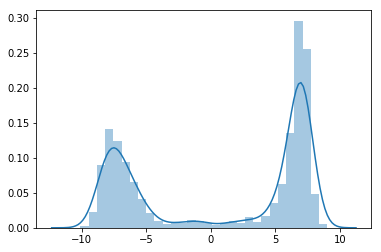

In [18]:
sns.distplot(samples_mixed_fs[0,:].cpu())

In [19]:
samples_mixed_fs.t().shape

torch.Size([80000, 2])

In [20]:
samples_mixed_fs.t().view(batch_size, 100, num_classes).shape

torch.Size([800, 100, 2])

In [21]:
samples_mixed_fs_transformed = samples_mixed_fs.t().view(batch_size, 100, num_classes).cpu()
samples_mixed_fs_transformed.shape

torch.Size([800, 100, 2])

In [22]:
samples_softmax = samples_softmax.cpu()

In [45]:
samples_mixed_fs_transformed[i,:,0].shape

torch.Size([100])

#########################################################
Class predicted: 0
Prediction == 0. Mean = 5.579. Std = 0.31
Prediction == 1. Mean = -5.581. Std = 0.313


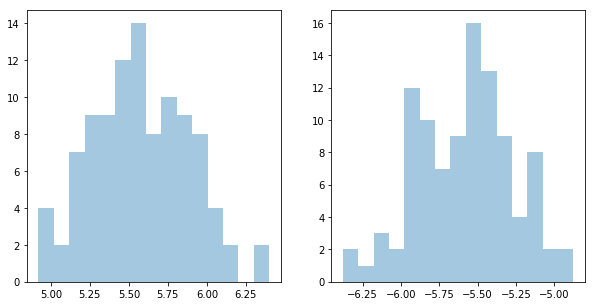

	Softmax


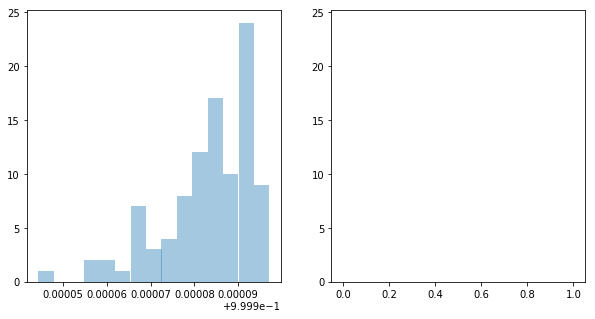

#########################################################
Class predicted: 1
Prediction == 0. Mean = -6.353. Std = 0.472
Prediction == 1. Mean = 6.367. Std = 0.471


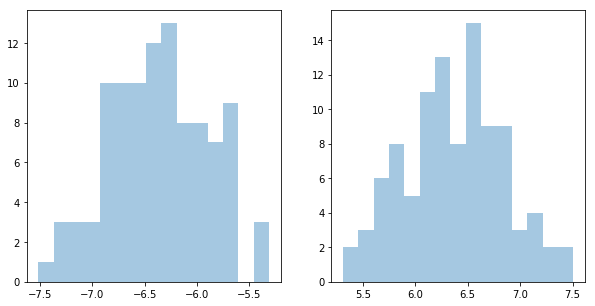

	Softmax


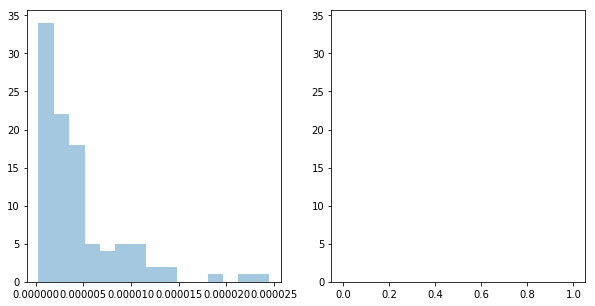

#########################################################
Class predicted: 0
Prediction == 0. Mean = 7.324. Std = 0.413
Prediction == 1. Mean = -7.327. Std = 0.416


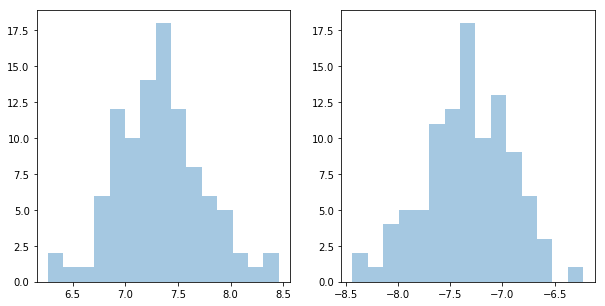

	Softmax


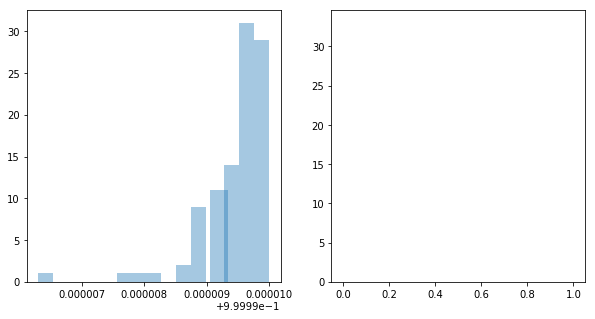

#########################################################
Class predicted: 0
Prediction == 0. Mean = 6.805. Std = 0.353
Prediction == 1. Mean = -6.808. Std = 0.355


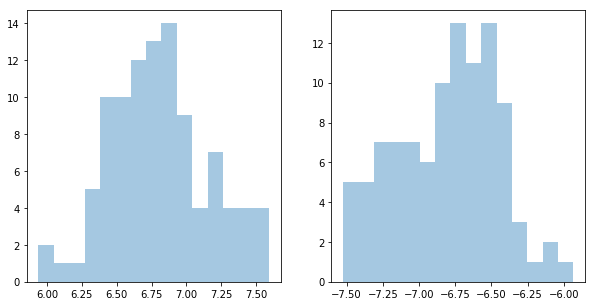

	Softmax


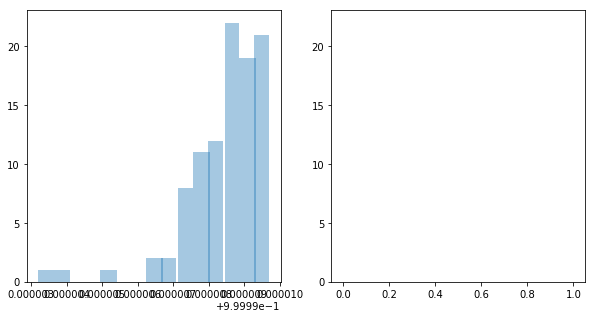

#########################################################
Class predicted: 1
Prediction == 0. Mean = -6.801. Std = 0.848
Prediction == 1. Mean = 6.798. Std = 0.845


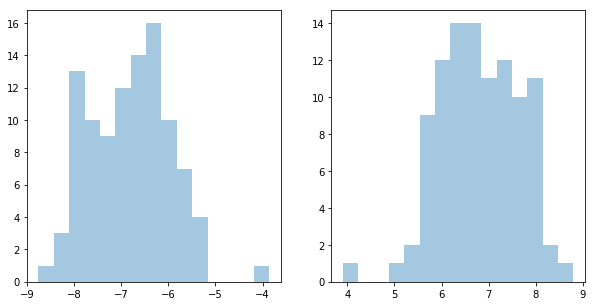

	Softmax


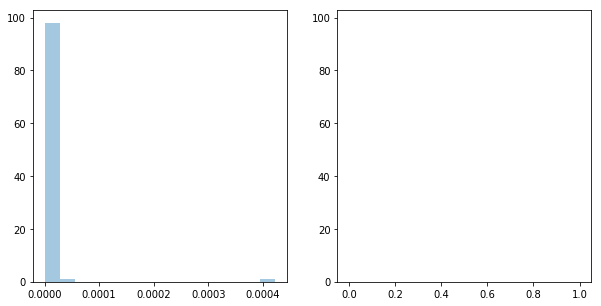

#########################################################
Class predicted: 1
Prediction == 0. Mean = -2.602. Std = 0.309
Prediction == 1. Mean = 2.619. Std = 0.315


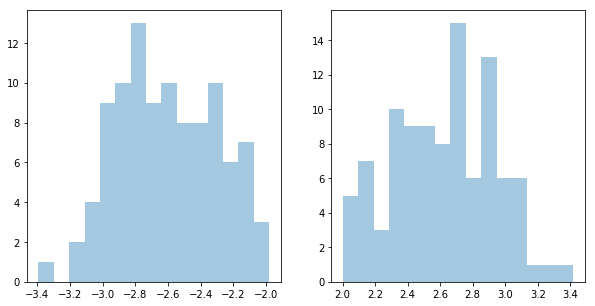

	Softmax


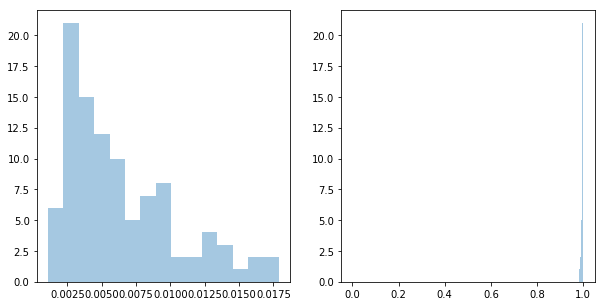

#########################################################
Class predicted: 0
Prediction == 0. Mean = 7.27. Std = 0.509
Prediction == 1. Mean = -7.269. Std = 0.512


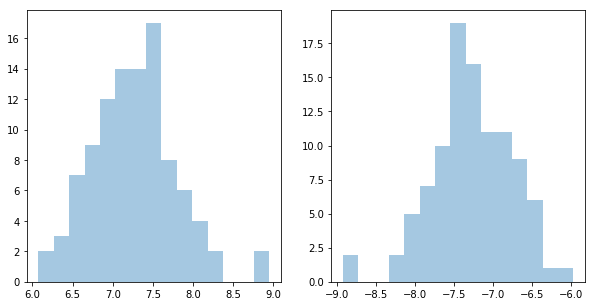

	Softmax


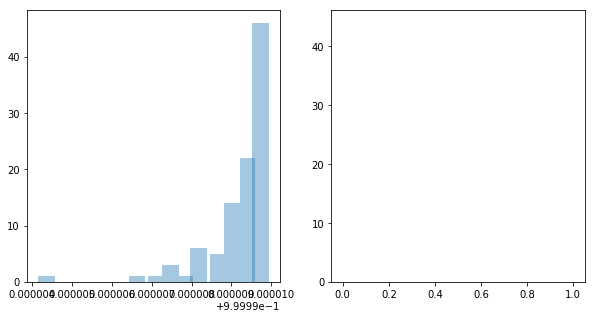

#########################################################
Class predicted: 0
Prediction == 0. Mean = 6.64. Std = 0.303
Prediction == 1. Mean = -6.646. Std = 0.313


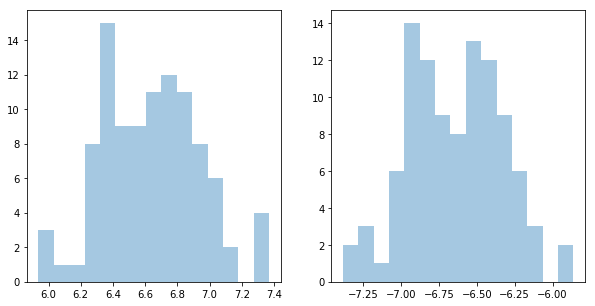

	Softmax


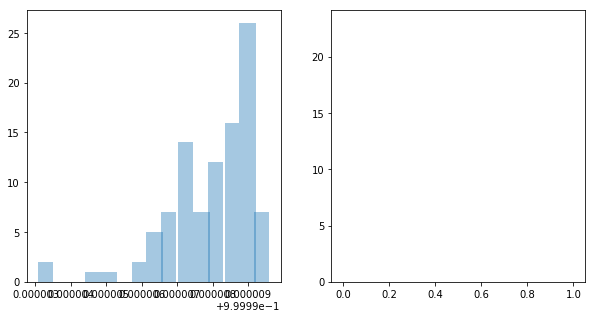

#########################################################
Class predicted: 1
Prediction == 0. Mean = -7.121. Std = 0.79
Prediction == 1. Mean = 7.117. Std = 0.781


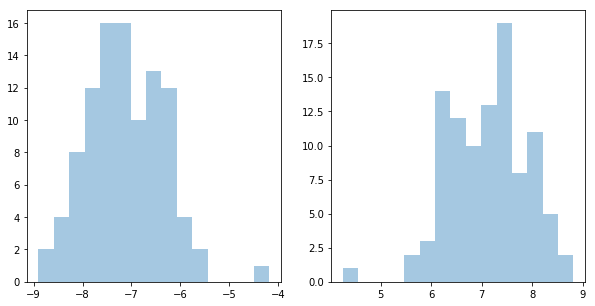

	Softmax


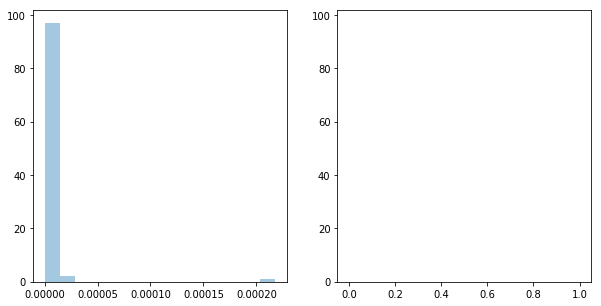

#########################################################
Class predicted: 1
Prediction == 0. Mean = -7.073. Std = 0.682
Prediction == 1. Mean = 7.081. Std = 0.673


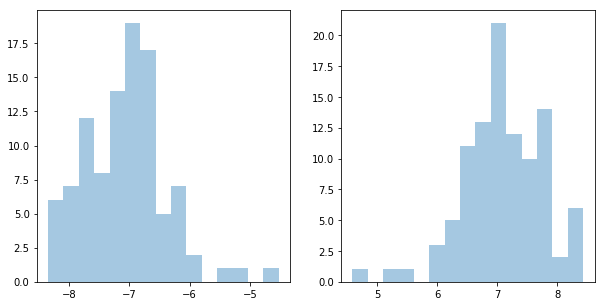

	Softmax


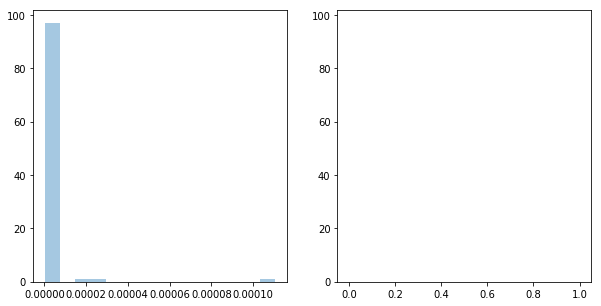

In [54]:
# for i in range(batch_size):
for i in range(10):
    print('#########################################################')
    print(f'Class predicted: {output.probs[i,:].cpu().argmax()}')
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    class_ = 0
    sns.distplot(samples_mixed_fs_transformed[i,:,class_], bins=15, kde=False)
    mean = float(torch.mean(samples_mixed_fs_transformed[i,:,class_]))
    std = float(torch.std(samples_mixed_fs_transformed[i,:,class_]))
    print(f'Prediction == {class_}. Mean = {round(mean, 3)}. Std = {round(std, 3)}')
#     plt.hist(samples_img[:, 0], bins=25)

    plt.subplot(122)
    class_ = 1
    sns.distplot(samples_mixed_fs_transformed[i,:,class_], bins=15, kde=False)
    mean = float(torch.mean(samples_mixed_fs_transformed[i,:,class_]))
    std = float(torch.std(samples_mixed_fs_transformed[i,:,class_]))
    print(f'Prediction == {class_}. Mean = {round(mean, 3)}. Std = {round(std, 3)}')
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     sns.distplot(samples_mixed_fs_transformed[i,:,:].reshape(-1), bins=50)
#     plt.show()
    print('\tSoftmax')
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    ax = sns.distplot(samples_softmax[i,:,0], bins=15, kde=False)
#     ax.set_xlim([-0.05,1.05])
#     plt.hist(samples_img[:, 0], bins=25)

    plt.subplot(122)
    ax = sns.distplot(samples_softmax[i,:,1], bins=15, kde=False)
    ax.set_xlim([-0.05,1.05])
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     sns.distplot(samples_softmax[i,:,:].reshape(-1), bins=500, kde=False)
#     plt.show()
    
    

NameError: name 'samples_img' is not defined

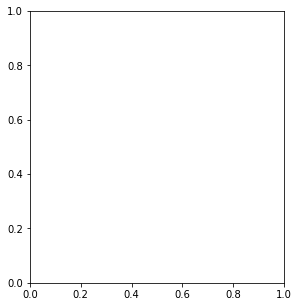

In [21]:
plot_hist(img_samples=samples_mixed_fs.transpose)